In [19]:
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
import seaborn as sns
import math
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.callbacks import ModelCheckpoint
from  tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import random
import shutil

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import zipfile
import os

# Path to the ZIP file
zip_file_path = "/content/drive/MyDrive/vishal/a.zip"

# Destination folder for unzipped files
destination_path = "/content/drive/MyDrive/vishal/unzipped_files"

# Create the destination folder if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Unzipping the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_path)

print(f"Files extracted to: {destination_path}")

Files extracted to: /content/drive/MyDrive/vishal/unzipped_files


In [20]:
np.random.seed(42)
tf.random.set_seed(42)

In [21]:
HEIGHT=224
WIDTH=224
BATCH_SIZE=32

In [22]:
# rescale pixel value [0,1]
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [23]:
# Train and test directory paths
train_dir = r"/content/drive/MyDrive/vishal/unzipped_files/a/train"
test_dir = r"/content/drive/MyDrive/vishal/unzipped_files/a/test"

# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Normalization for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    classes={'Alternaria': 0, 'Anthracnose': 1, 'Bacterial_Blight': 2, 'Cercospora': 3, 'Healthy': 4}
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    classes={'Alternaria': 0, 'Anthracnose': 1, 'Bacterial_Blight': 2, 'Cercospora': 3, 'Healthy': 4}
)

Found 5800 images belonging to 5 classes.
Found 1450 images belonging to 5 classes.


In [24]:
total_image = np.concatenate([train_generator.labels,test_generator.labels])

In [25]:

print('Alternaria: ',len(np.where(total_image==0)[0]))
print('Anthracnose: ',len(np.where(total_image==1)[0]))
print('Bacterial_Blight: ',len(np.where(total_image==2)[0]))
print('Cercospora: ',len(np.where(total_image==3)[0]))
print('Healthy: ',len(np.where(total_image==4)[0]))


Alternaria:  1450
Anthracnose:  1450
Bacterial_Blight:  1450
Cercospora:  1450
Healthy:  1450


In [26]:

train_generator.labels.shape

(5800,)

In [27]:
np.unique(train_generator.labels)

array([0, 1, 2, 3, 4], dtype=int32)

In [28]:

images, labels = next(train_generator)

In [29]:

labels.shape

(32,)

In [30]:
def plot_images(images_arr, labels_arr, class_indices):
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20,20))
    axes = axes.flatten()
    for img, lbl, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        label = list(class_indices.keys())[list(class_indices.values()).index(int(lbl))]
        ax.set_title(label)
    plt.tight_layout()
    plt.show()


In [31]:
labels[:5]

array([4., 0., 0., 1., 0.], dtype=float32)

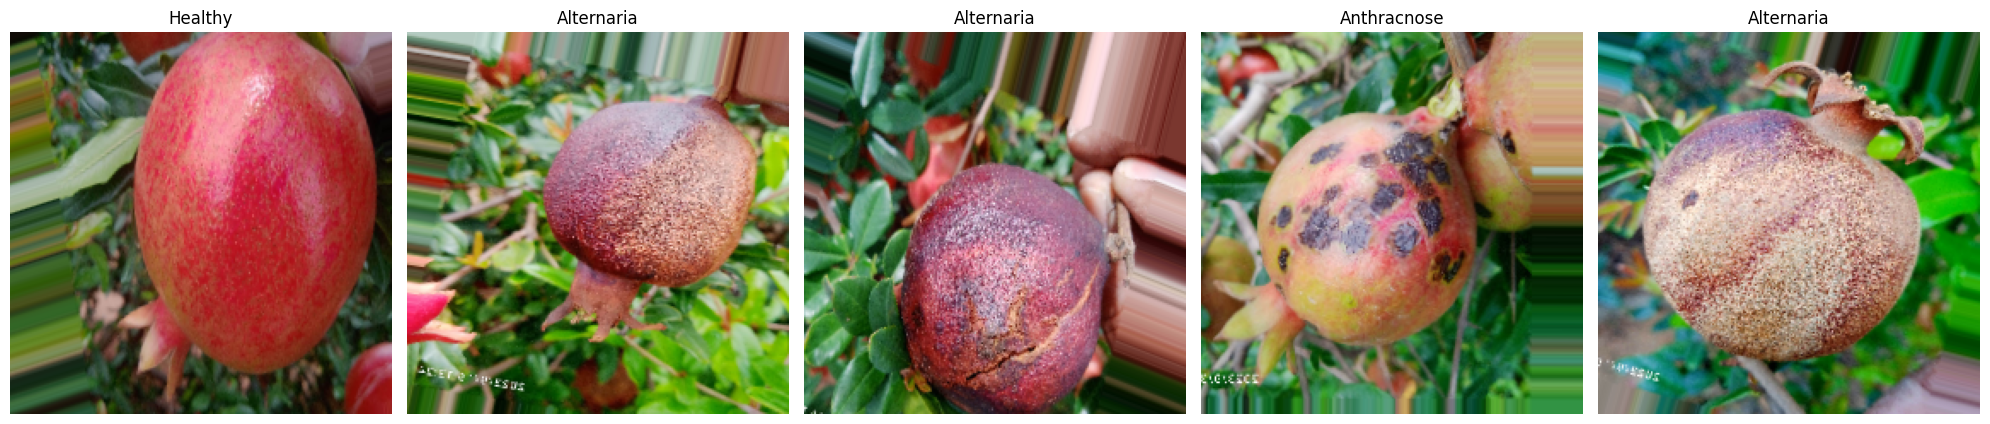

In [32]:

# Display first 5 images from the batch
plot_images(images[:5], labels[:5], train_generator.class_indices)

In [33]:

tf.keras.backend.clear_session()


In [37]:
# Ensure train_generator is properly initialized
num_classes = len(train_generator.class_indices)  # Dynamically calculate the number of classes
print("Number of classes:", num_classes)

# One-hot encode labels
from tensorflow.keras.utils import to_categorical

train_labels_one_hot = to_categorical(train_generator.labels, num_classes=num_classes)
test_labels_one_hot = to_categorical(test_generator.labels, num_classes=num_classes)


Number of classes: 5


In [38]:

# Loading VGG16 Model with Pre-trained Weights - without final (top) later as we will customize it
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(HEIGHT, WIDTH, 3))

In [39]:
for layer in base_model.layers:
    layer.trainable = False

In [40]:
num_classes = len(train_generator.class_indices)
print('Number of classes:', num_classes)

Number of classes: 5


In [41]:
# # 3. Fine-tune the Model
# model = Sequential()
# model.add(base_model)
# # model.add(Flatten())
# # model.add(Dense(512, activation='relu'))
# # model.add(Dropout(0.5))
# # model.add(Dense(num_classes, activation='softmax'))

# model.add(GlobalAveragePooling2D())

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))

# #
# model.add(Dense(5, activation='softmax'))  # for 5 classes


model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [42]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,913,093 (56.89 MB)

 Trainable params: 198,405 (775.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',  # For integer-encoded labels
    metrics=['accuracy']  # Only accuracy
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16_best_weights.weights.h5',  # Save weights only
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    restore_best_weights=True,
    patience=5
)

callbacks_list = [checkpoint, early]
# Fit the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=callbacks_list,
    verbose=True,
    shuffle=True
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3690 - loss: 1.4553
Epoch 1: val_accuracy improved from -inf to 0.82000, saving model to vgg16_best_weights.weights.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 587s 3s/step - accuracy: 0.3699 - loss: 1.4538 - val_accuracy: 0.8200 - val_loss: 0.5770
Epoch 2/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7646 - loss: 0.6345
Epoch 2: val_accuracy improved from 0.82000 to 0.87241, saving model to vgg16_best_weights.weights.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 531s 3s/step - accuracy: 0.7647 - loss: 0.6343 - val_accuracy: 0.8724 - val_loss: 0.3429
Epoch 3/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8353 - loss: 0.4634
Epoch 3: val_accuracy improved from 0.87241 to 0.89862, saving model to vgg16_best_weights.weights.h5
182/182 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.8353 - loss: 0.4633 - val_accuracy: 0.8986 - val_loss: 0.2714
Epoch 4/10
182/182 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8703 - loss: 0.3777
Epoch 4: val_a

In [1]:

model.save('vgg16_complete_model.h5')

NameError: name 'model' is not defined

In [ ]:
def plot_learning_curve(history, metrics):
    acc = history.history[metrics]
    val_acc = history.history[f'val_{metrics}']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(5,3))
    plt.plot(epochs, acc, label=f'training {metrics}')
    plt.plot(epochs, val_acc, label=f'validation {metrics}')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel(metrics)
    plt.legend()

    plt.figure(figsize=(5,3))
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:

plot_learning_curve(history, metrics='accuracy')

In [ ]:
# def f1_score(y_true, y_pred):
#     def recall(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#         recall = true_positives / (possible_positives + K.epsilon())
#         return recall

#     def precision(y_true, y_pred):
#         true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#         predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#         precision = true_positives / (predicted_positives + K.epsilon())
#         return precision

#     precision_val = precision(y_true, y_pred)
#     recall_val = recall(y_true, y_pred)
#     return 2 * ((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',  # For one-hot encoded labels
    metrics=['accuracy']
)


# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16_best_weights.weights.h5',  # Save weights only
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_weights_only=True
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    restore_best_weights=True,
    patience=5
)

callbacks_list = [checkpoint, early]

# Fit the model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=callbacks_list,
    verbose=True,
    shuffle=True
)

In [ ]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val) / (precision_val + recall_val + K.epsilon()))


model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=[f1_score])


In [ ]:
!pip install keras>=3.5.0
import keras
print(keras.version)

In [52]:

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='vgg16_best_weights.weights.h5',  # Updated to `.weights.h5`
    monitor='val_accuracy',
    verbose=1,
    mode='max',
    save_best_only=True,
    save_weights_only=True  # Saving only weights
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    mode="min",
    restore_best_weights=True,
    patience=5
)

callbacks_list = [checkpoint, early]


In [53]:
# pip install tensorflow


In [54]:

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    callbacks=[callbacks_list],
    verbose=True,
    shuffle=True)

Epoch 1/5


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 5)